# Book Recommendation System Project

Using the goodbooks kaggle dataset to create a book recommendation system through content-based and collaborative filtering

In [1]:
import string
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz

## Reading in the Data
    books.csv - GoodReads information about all books
    ratings.csv - Rating of a book by a specific user
    book_tags.csv - Tags assigned to books by users represented by their index
    tags.csv - Mapping from tag index to tag name

In [2]:
books= pd.read_csv('books.csv',error_bad_lines = False)
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [3]:
ratings = pd.read_csv('ratings.csv')
ratings.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [4]:
tags = pd.read_csv('book_tags.csv')
tags.tail()

,goodreads_book_id,tag_id,count
999907,33288638,21303,7
999908,33288638,17271,7
999909,33288638,1126,7
999910,33288638,11478,7
999911,33288638,27939,7


In [5]:
i_to_tag = pd.read_csv('tags.csv')
i_to_tag.tail()

,tag_id,tag_name
34247,34247,Ｃhildrens
34248,34248,Ｆａｖｏｒｉｔｅｓ
34249,34249,Ｍａｎｇａ
34250,34250,ＳＥＲＩＥＳ
34251,34251,ｆａｖｏｕｒｉｔｅｓ


## Cleaning the data

Ordering ratings by user and removing duplicates

In [6]:
ratings = ratings.sort_values("user_id")
ratings.head()

,book_id,user_id,rating
117889,1180,1,4
488112,4893,1,3
625717,6285,1,4
796318,8034,2,4
875008,8855,2,5


In [7]:
ratings.drop_duplicates(subset=["user_id","book_id"], keep = False, inplace = True) 

books.drop_duplicates(subset = 'original_title', keep=False, inplace=True)

i_to_tag.drop_duplicates(subset='tag_id', keep=False, inplace=True)

tags.drop_duplicates(subset=['goodreads_book_id', 'tag_id'], keep=False, inplace=True)

## Exploratory Analysis of Data

Visualizing most common rating, number of ratings per book, and correlation between rating and other statistics

### Most Common Ratings

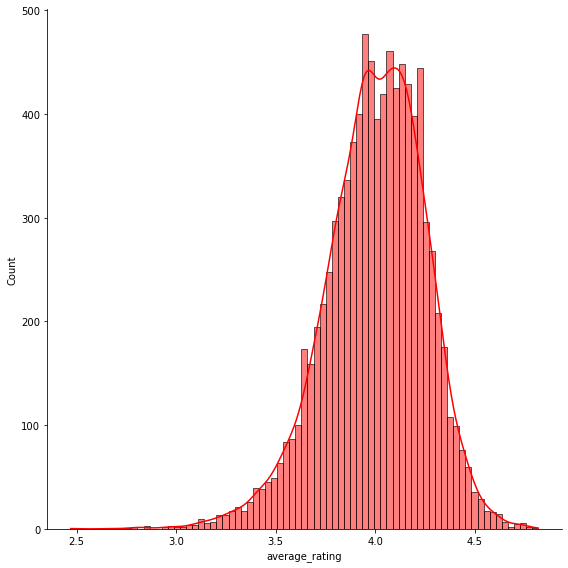

In [8]:
sns.displot(data=books, x='average_rating', kde=True, color='r', height=8)

We see that most books have a rating between 3.5 and 4.0

### Number of ratings per book

In [9]:
r = ratings.groupby(['book_id']).count()
r

,user_id,rating
book_id,,
1,100,100
2,100,100
3,100,100
4,100,100
5,100,100
...,...,...
9996,96,96
9997,89,89
9998,95,95


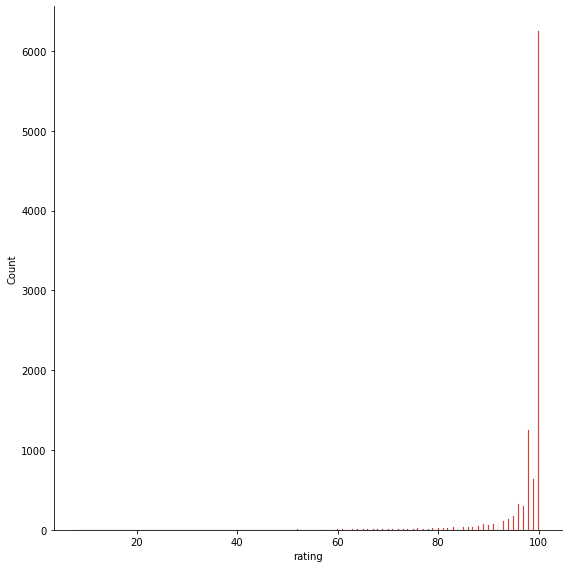

In [10]:
sns.displot(data=r, x='rating', color='r', height=8)

Most books have over 80 reviews in this datsa set

### Checking Correlation Between Ratings and Other Factors

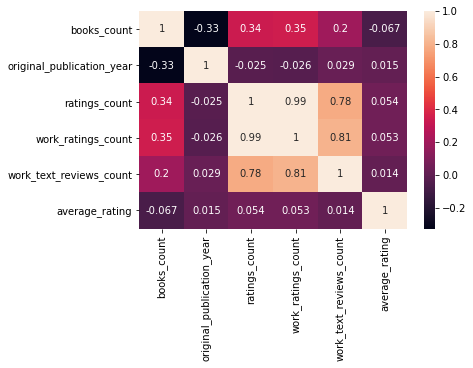

In [11]:
corrs = books[["books_count","original_publication_year","ratings_count", "work_ratings_count", "work_text_reviews_count", "average_rating"]].corr()
sns.heatmap(corrs, annot=True)
plt.show()

It appears that none of the other attributes of the book are closely correlated to the average rating, suggesting that the rating is based off of another factor, such as the quality of the book. Thus, our system cannot rely on any of the factors seen above

## Content Based Filtering System

This system recommends books based on the title, author, tags and average rating of the book using KNN and cosine similarity between books.

Filling missing data values, converting to lowercase and extracting relevant features.

In [12]:
cleanbooks = books.fillna('')

def clean(word):
    return str.lower(word)

features = ['original_title','authors','average_rating', 'book_id']
cleanbooks = cleanbooks[features]
cleanbooks = cleanbooks.astype(str)


for feature in features:
    cleanbooks[feature] = cleanbooks[feature].apply(clean)
    


Merging the dataframes containing the tag_id's for each book and the tag names, then displaying the 200 most used tags. Since the tags are user assigned, we will select the relevant tags out of the top 200 to use in the system.

In [13]:
joint_tags = pd.merge(tags, i_to_tag, left_on='tag_id', right_on='tag_id', how='inner')

p = joint_tags.groupby('tag_name').count()
p = p.sort_values(by='count', ascending=False)

pd.set_option('display.max_rows', 200)
p.head(200)
    


,goodreads_book_id,tag_id,count
tag_name,,,
to-read,9983,9983,9983
favorites,9881,9881,9881
owned,9856,9856,9856
books-i-own,9799,9799,9799
currently-reading,9776,9776,9776
library,9415,9415,9415
owned-books,9221,9221,9221
fiction,9097,9097,9097
to-buy,8692,8692,8692


From these 200 tags, we choose the following genres and drop all the other tags from the data. 

In [14]:
genres = ['fiction', 'adult', 'series', 'adult-fiction', 'fantasy', 'romance', 'novel', 'mystery', 'adventure', 
         'young-adult', 'drama', 'ya', 'classics', 'contemporary-fiction', 'historical-fiction', 'historical', 
          'thriller', 'sci-fi-fantasy', 'suspense', 'sci-fi', 'science-fiction', 'action', 'humor', 'family',
         'non-fiction', 'crime', 'paranormal', 'classic', 'mystery-thriller', 'teen', 'supernatural', 'nonfiction',
         'realistic-fiction', 'literary-fiction', 'funny', 'scifi-fantasy', 'ya-fiction', 'mystery-suspense', 
         'mysteries', 'horror', 'thrillers', 'young-adult-fiction', 'ya-books', 'scifi']

new_joint = joint_tags[joint_tags.tag_name.isin(genres)]
new_joint

,goodreads_book_id,tag_id,count,tag_name
9983,1,11305,37174,fantasy
9984,2,11305,3441,fantasy
9985,3,11305,47478,fantasy
9986,5,11305,39330,fantasy
9987,6,11305,38378,fantasy
...,...,...,...,...
698479,29981261,20989,38,mystery-suspense
698480,30008702,20989,11,mystery-suspense
698481,30314465,20989,9,mystery-suspense
698482,31176886,20989,34,mystery-suspense


Now we combine all the tags for each book, rename the book id column, and ensure we have one row per book.

In [15]:
combined = new_joint[['goodreads_book_id', 'tag_name']].copy()
combined['tag_name'] = combined.groupby(['goodreads_book_id'])['tag_name'].transform(lambda x : ' '.join(x))
combined.rename(columns={'goodreads_book_id' : 'book_id'}, inplace=True)

combined.reset_index(inplace=True)
combined.drop("index",axis=1,inplace=True)

final_tags = pd.DataFrame.drop_duplicates(combined)
final_tags = final_tags.astype(str)
final_tags



,book_id,tag_name
0,1,fantasy young-adult fiction ya series adventur...
1,2,fantasy young-adult fiction ya paranormal teen...
2,3,fantasy young-adult fiction ya series adventur...
3,5,fantasy young-adult fiction ya series adventur...
4,6,fantasy young-adult fiction ya series adventur...
...,...,...
91014,11942408,non-fiction
91130,16170625,non-fiction historical
91220,21394850,non-fiction
91245,22931009,non-fiction


Adding a new column containing the book title, author, rating and tags as a string.

In [16]:
def create_str(x):
    mstr =  x['original_title']+ ' ' + x['authors'] + ' ' + x['average_rating'] +' ' + x['tag_name']
    return mstr


book_info = pd.merge(cleanbooks, final_tags, left_on='book_id', right_on='book_id', how='inner')
book_info['book_str'] = book_info.apply(create_str, axis=1)

book_info.head(10)

,original_title,authors,average_rating,book_id,tag_name,book_str
0,the hunger games,suzanne collins,4.34,2767052,fantasy young-adult fiction ya series adventur...,the hunger games suzanne collins 4.34 fantasy ...
1,harry potter and the philosopher's stone,"j.k. rowling, mary grandpré",4.44,3,fantasy young-adult fiction ya series adventur...,harry potter and the philosopher's stone j.k. ...
2,to kill a mockingbird,harper lee,4.25,2657,young-adult fiction ya classics mystery novel ...,to kill a mockingbird harper lee 4.25 young-ad...
3,the great gatsby,f. scott fitzgerald,3.89,4671,young-adult fiction classics novel romance cla...,the great gatsby f. scott fitzgerald 3.89 youn...
4,the fault in our stars,john green,4.26,11870085,young-adult fiction ya teen ya-fiction young-a...,the fault in our stars john green 4.26 young-a...
5,the hobbit or there and back again,j.r.r. tolkien,4.25,5907,fantasy young-adult fiction ya series adventur...,the hobbit or there and back again j.r.r. tolk...
6,the catcher in the rye,j.d. salinger,3.79,5107,young-adult fiction ya classics teen novel cla...,the catcher in the rye j.d. salinger 3.79 youn...
7,angels & demons,dan brown,3.85,960,fantasy fiction series adventure classics myst...,angels & demons dan brown 3.85 fantasy fictio...
8,pride and prejudice,jane austen,4.24,1885,young-adult fiction classics novel romance cla...,pride and prejudice jane austen 4.24 young-adu...
9,the kite runner,khaled hosseini,4.26,77203,young-adult fiction classics novel classic con...,the kite runner khaled hosseini 4.26 young-ad...


Vectorizing the book string and computing a cosine similarity matrix across the books, and getting the book indicies to use later.

In [17]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(book_info['book_str'])


cosine_sim2 = cosine_similarity(count_matrix, count_matrix)


book_info = book_info.reset_index()
indices = pd.Series(book_info.index, index=book_info['original_title'])

Function to get recommendations based on the computed cosine similarities

In [18]:
def get_recs(title, cosine_sim = cosine_sim2):
    title = title.lower()
    idx = indices[title]

    # Get the pairwsie similarity scores of all books with the inputted book
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the books based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar books
    sim_scores = sim_scores[1:11]

    # Get the book indices
    book_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar books
    return list(books['original_title'].iloc[book_indices])

Trying out the system with some popular books

In [19]:
l = get_recs('Harry Potter and The Chamber of Secrets', cosine_sim2)

for book in l:
    print(book)


[(22, 0.9495433918790783), (1, 0.9400000000000002), (23, 0.9307386903980732), (16, 0.9109357395385398), (25, 0.9109357395385398), (398, 0.8837516331823905), (3549, 0.8643558937793567), (19, 0.8600000000000001), (5130, 0.8552359741197582), (376, 0.8528028654224418)]
Harry Potter and the Goblet of Fire
Harry Potter and the Philosopher's Stone
Harry Potter and the Deathly Hallows
Harry Potter and the Prisoner of Azkaban
Harry Potter and the Half-Blood Prince
Complete Harry Potter Boxed Set
Harry Potter Collection (Harry Potter, #1-6)
Harry Potter and the Order of the Phoenix
Greenwitch
The Tales of Beedle the Bard


In [20]:
l = get_recs("Divergent", cosine_sim2)

for book in l:
    print(book)

[(999, 0.9739498664755512), (65, 0.9565579045742021), (99, 0.9565579045742021), (2341, 0.947514248563855), (1147, 0.9414756947947212), (5064, 0.9379030918551612), (2478, 0.9323373174786144), (7432, 0.9284766908852594), (1353, 0.923110640934333), (2192, 0.923110640934333)]
Four: A Divergent Collection
Insurgent
Allegiant
Four: The Transfer
Free Four: Tobias Tells the Divergent Story
Four: The Initiate
The Fall of Five
Four: The Son
Under the Never Sky
The Ask and the Answer


In [21]:
l = get_recs('The Hunger Games', cosine_sim2)

for book in l:
    print(book)

[(481, 0.9719273929377944), (15, 0.9637347395355396), (18, 0.9566222088265403), (678, 0.9064982793336027), (177, 0.9043241663265434), (744, 0.9043241663265434), (2192, 0.902511963929742), (2660, 0.902511963929742), (928, 0.901497871710418), (2268, 0.901497871710418)]
The Hunger Games Box Set
Catching Fire
Mockingjay
Unwind
Uglies
Specials
The Ask and the Answer
The Testing
Steelheart
The Final Warning


## Collaborative Filtering System

Collaborative filtering uses the ratings that users have assigned to books to give a user recommendations based on other users like them. 

Selecting only the needed columns and dropping missing data.

In [22]:
books_col = books[['book_id', 'original_title']]
books_col.dropna()

,book_id,original_title
0,2767052,The Hunger Games
1,3,Harry Potter and the Philosopher's Stone
3,2657,To Kill a Mockingbird
4,4671,The Great Gatsby
5,11870085,The Fault in Our Stars
...,...,...
9995,7130616,Bayou Moon
9996,208324,Means of Ascent
9997,77431,The Mauritius Command
9998,8565083,Cinderella Ate My Daughter: Dispatches from th...


First we explore the distribution of ratings to see how much data we have to determine which books we have sufficent data for.

In [23]:
num_users = len(ratings.user_id.unique())
num_items = len(ratings.book_id.unique())
ratings = ratings.dropna()

temp_count = pd.DataFrame(ratings.groupby('rating').size(), columns=['count'])

total = num_users * num_items
zero_count = total - ratings.shape[0]

rating_counts = temp_count.append(pd.DataFrame({'count': zero_count}, index=[0.0]),
                                           verify_integrity=True,).sort_index()

rating_counts


,count
0.0,532822731
1.0,19485
2.0,63010
3.0,247698
4.0,355878
5.0,291198


Most books have not been rated by these users and thus need to be dropped. We will consider books with over 50 ratings and users that have rated at least 30 books to ensure sufficent data for the model.

Getting the number of ratings per book:

In [24]:
df_books_cnt = pd.DataFrame(ratings.groupby('book_id').size(), columns=['count'])
df_books_cnt

,count
book_id,
1,100
2,100
3,100
4,100
5,100
...,...
9996,96
9997,89
9998,95


Dropping books with under 50 ratings

In [25]:
book_thres = 50
pop_books = list(set(df_books_cnt.query('count >= @book_thres').index))
df_ratings_drop = ratings[ratings.book_id.isin(pop_books)]

print('Original number of book ratings: ', ratings.shape[0])
print('Number of ratings after dropping unpopular books: ', df_ratings_drop.shape[0])

Original number of book ratings:  977269
Number of ratings after dropping unpopular books:  976884


Getting the number of ratings per user

In [26]:
df_users_cnt = pd.DataFrame(df_ratings_drop.groupby('user_id').size(), columns=['count'])
df_users_cnt

,count
user_id,
1,3
2,3
3,2
4,3
5,5
...,...
53420,6
53421,8
53422,18


Dropping users that have rated under 50 books

In [27]:
user_thres = 30
active_users = list(set(df_users_cnt.query('count >= @user_thres').index))
df_ratings_drop_users = df_ratings_drop[df_ratings_drop.user_id.isin(active_users)]
print('Original number of books ratings: ', ratings.shape[0])
print('Number of ratings after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape[0])

Original number of books ratings:  977269
Number of ratings after dropping both unpopular movies and inactive users:  601798


Transforming the ratings data frame into a matrix of users and book ratings and then compressing into a sparse row matrix.

In [28]:
book_user_mat = df_ratings_drop_users.pivot(index='book_id', columns='user_id', values='rating').fillna(0)
book_user_mat

user_id,7,23,35,41,46,47,49,75,82,89,...,53339,53348,53352,53364,53366,53372,53373,53381,53401,53403
book_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
book_user_mat_sparse = csr_matrix(book_user_mat.values)
book_user_mat_sparse

<9984x9737 sparse matrix of type '<class 'numpy.float64'>'
	with 601798 stored elements in Compressed Sparse Row format>

Create the KNN model using sklearn.neighbors and fit to the sparse matrix

In [30]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

model_knn.fit(book_user_mat_sparse)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [31]:
indices = pd.Series(books_col.index, index=books_col['original_title'])

def fuzzy_matching(mapper, fav_book, verbose=True):
    match_tuple = []

    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_book.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
            
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]


In [32]:
def make_recommendation(model_knn, data, mapper, title, n_recommendations):

    model_knn.fit(data)
    
    print('You have input book:', title)
    idx = fuzzy_matching(mapper, title)
    
    print('Recommendation system starting to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    
    raw_recommends =  sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]

    reverse_mapper = {v: k for k, v in mapper.items()}

    
    print('Recommendations for {}:'.format(title))
    rec=[]
    for i, (idx, dist) in enumerate(raw_recommends):
        if idx not in reverse_mapper.keys():
            continue
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))
        rec.append(reverse_mapper[idx])
    return rec

In [33]:
make_recommendation(model_knn=model_knn, data=book_user_mat_sparse, title="Divergent",mapper=indices, 
                    n_recommendations=10)

You have input book: Divergent
Found possible matches in our database: ['Divergent', 'Evergreen', 'Driven', 'Insurgent', 'Descent', 'Deliverance']

Recommendation system starting to make inference
......

Recommendations for Divergent:
1: Mockingjay, with distance of 0.6368451672358991
2: Catching Fire, with distance of 0.6317072362567975
3: Insurgent, with distance of 0.6143238462674122
4: The Giver, with distance of 0.608207539785535
6: The Perks of Being a Wallflower, with distance of 0.601842439360365
7: The Book Thief, with distance of 0.5813217330602747
8: The Lightning Thief, with distance of 0.5660509401292786
9: Gone Girl, with distance of 0.5627069805246723
10: The Fault in Our Stars, with distance of 0.41485257342792325


['Mockingjay',
 'Catching Fire',
 'Insurgent',
 'The Giver',
 'The Perks of Being a Wallflower',
 'The Book Thief',
 'The Lightning Thief',
 'Gone Girl',
 'The Fault in Our Stars']

In [34]:
make_recommendation(model_knn=model_knn, data=book_user_mat_sparse, title="The Adventures of Huckleberry Finn",mapper=indices, 
                    n_recommendations=10)

You have input book: The Adventures of Huckleberry Finn
Found possible matches in our database: ['The Adventures of Huckleberry Finn', 'Tom Sawyer & Huckleberry Finn', 'The Adventures of Sherlock Holmes', 'The Adventures of Augie March', 'The Adventures of Tom Sawyer', 'The Complete Adventures of Peter Rabbit', 'The Adventures of Captain Underpants', 'The Merry Adventures of Robin Hood', 'The Amazing Adventures of Kavalier & Clay', 'The Return of the King', 'The Wives of Henry VIII', 'The Nature of the Beast']

Recommendation system starting to make inference
......

Recommendations for The Adventures of Huckleberry Finn:
1: Brave New World, with distance of 0.49855917550721673
2: Little Women, with distance of 0.4971527007052505
3: Animal Farm: A Fairy Story, with distance of 0.4929486947501913
4: Lord of the Flies , with distance of 0.49269240241892387
5: The Hobbit or There and Back Again, with distance of 0.4911537681911242
6: The Old Man and the Sea, with distance of 0.49007626094

['Brave New World',
 'Little Women',
 'Animal Farm: A Fairy Story',
 'Lord of the Flies ',
 'The Hobbit or There and Back Again',
 'The Old Man and the Sea',
 'Sense and Sensibility',
 'Of Mice and Men ',
 'An Excellent conceited Tragedie of Romeo and Juliet',
 'The Adventures of Tom Sawyer']

In [36]:
make_recommendation(model_knn=model_knn, data=book_user_mat_sparse, title="Ready Player One",mapper=indices, 
                    n_recommendations=10)

You have input book: Ready Player One
Found possible matches in our database: ['Ready or Not', 'The Player of Games', 'Reaper Man', 'Dead and Gone']

Recommendation system starting to make inference
......

Recommendations for Ready Player One:
1: Starlight (Warriors: The New Prophecy, #4), with distance of 0.49006923910945177
2: Dark Gold (Dark #3), with distance of 0.4374956975588997
3: The Expats, with distance of 0.37985007115306724
4: Neil Patrick Harris: Choose Your Own Autobiography, with distance of 0.3582959674498071
5: The Lost Prince, with distance of 0.29083102512826
6: The Onion Field, with distance of 0.27411095784300676
7: And Another Thing... (Hitchhiker's Guide to the Galaxy, #6), with distance of 0.2393899242736678
9: Law Man, with distance of 0.22316450689274214
10: Cleopatra's Daughter, with distance of 0.22230126627344038


['Starlight (Warriors: The New Prophecy, #4)',
 'Dark Gold (Dark #3)',
 'The Expats',
 'Neil Patrick Harris: Choose Your Own Autobiography',
 'The Lost Prince',
 'The Onion Field',
 "And Another Thing... (Hitchhiker's Guide to the Galaxy, #6)",
 'Law Man',
 "Cleopatra's Daughter"]